In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import numpy as np
from astropy.stats import mad_std, SigmaClip, sigma_clipped_stats
from astropy.nddata import CCDData
import pandas as pd
from photutils.detection import DAOStarFinder
from photutils import *
from astropy.io import fits
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from astropy.table import Table
from astropy import units as u
import sys
sys.path.insert(0, '/Users/josue/kosmos/')
import warnings
warnings.filterwarnings('ignore')
import kosmos

In [2]:
# Creats a directory array
def dir_array(D, j):
    i = pd.read_table(D + j, names=['impath'])
    k = D + i['impath'].values
    #print(k)
    return k

# SS Cyg in the i filter
def reduce(dir_array, bias, flat):
    sciimg_array = []
    for i in dir_array:
        sci = i
        sciimg = kosmos.proc(sci, bias=bias, ilum=None, flat=flat, trim=None)
        sciimg_array.append(sciimg)
    return sciimg_array

# gets header 
def get_header(dir_arrray, HEADER):
    j = []
    for i in dir_arrray:
        hdu_list = fits.open(i)
        a = hdu_list[0].header[HEADER]
        j.append(a)
    return j

# Magnitude function 
def makemag(flux,exptime,C):
    m = C - 2.5 * np.log(np.abs(flux / exptime))
    return m

In [26]:
# First night
dir = 'C:/Users/josue/Work-space/data/07082022/'

# Master bias
biasfiles_1 = pd.read_table(dir + 'bias_08.txt', names=['impath'])
biasfiles1 = dir + biasfiles_1['impath'].values
bias = kosmos.biascombine(biasfiles1)

# Master flats
i_flats = dir_array(dir, "sky_flats_V.txt")
flat_i = kosmos.flatcombine(i_flats, bias=bias, trim=None, illumcor=False)

# Reduced object SS Cyg
ss_cyg1 = dir_array(dir, "g9348.txt")
SS_Cyg1 = reduce(ss_cyg1, bias, flat_i)

# SS Cyg not reduced
ss_cyg_r = CCDData.read(ss_cyg1[4])

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

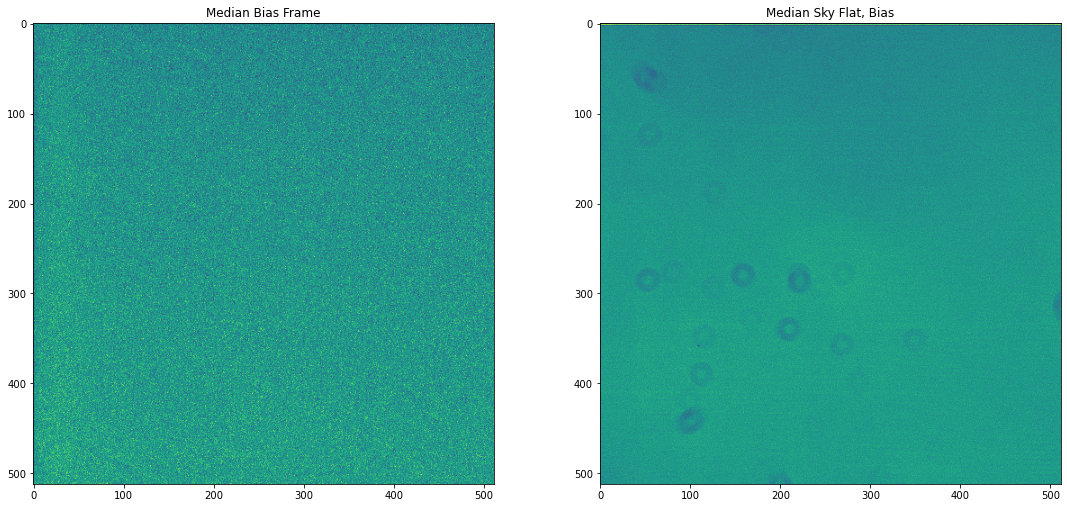

In [28]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
fig.tight_layout(w_pad=7.5, h_pad=5.5)

# Bias 
ax[0].imshow(bias)
ax[0].title.set_fontsize(20)
ax[0].set_title('Median Bias Frame');

# flat
ax[1].imshow(flat_i)
ax[1].title.set_fontsize(20)
ax[1].set_title('Median Sky Flat, Bias');

8.908621565907115


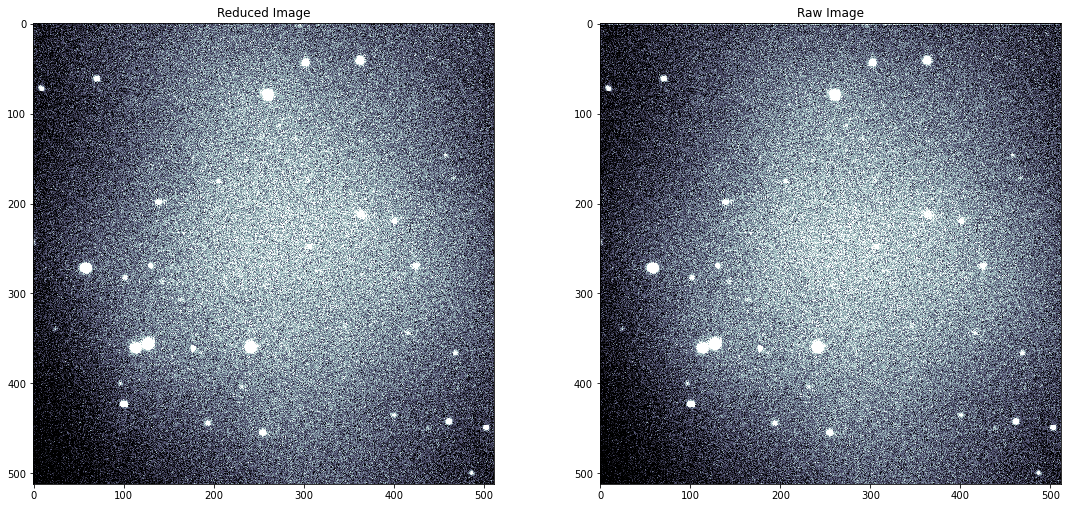

In [45]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
fig.tight_layout(w_pad=7.5, h_pad=5.5)

ax[0].imshow(SS_Cyg1[4], vmin=np.percentile(SS_Cyg1[4], 5), 
             vmax=np.percentile(SS_Cyg1[4], 98), cmap='bone', interpolation='nearest');
ax[0].title.set_fontsize(20)
ax[0].set_title('Reduced Image');

ax[1].imshow(ss_cyg_r, vmin=np.percentile(ss_cyg_r, 5), 
             vmax=np.percentile(ss_cyg_r, 98), cmap='bone', interpolation='nearest');
ax[1].title.set_fontsize(20)
ax[1].set_title('Raw Image');
print(np.mean(SS_Cyg1[4]))

## Finding Flux

In [37]:
m = 4
mean, median, std = sigma_clipped_stats(SS_Cyg1[m], sigma=3.0)
step = SS_Cyg1[m].data
sciimg_data = np.ma.getdata(step)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 260.61541868557174 ... 1.3802021667179545 -0.34985676212523376
  2  58.10847589836796 ... 1.4257465936007994  -0.3851058566008744
  3 127.39462580321386 ... 1.7660251379358658   -0.617492202788378
  4  241.5010155083057 ...   1.29730855385468   -0.282608204087275
  5 113.67632672203324 ... 1.1630599255133833 -0.16400522974741433


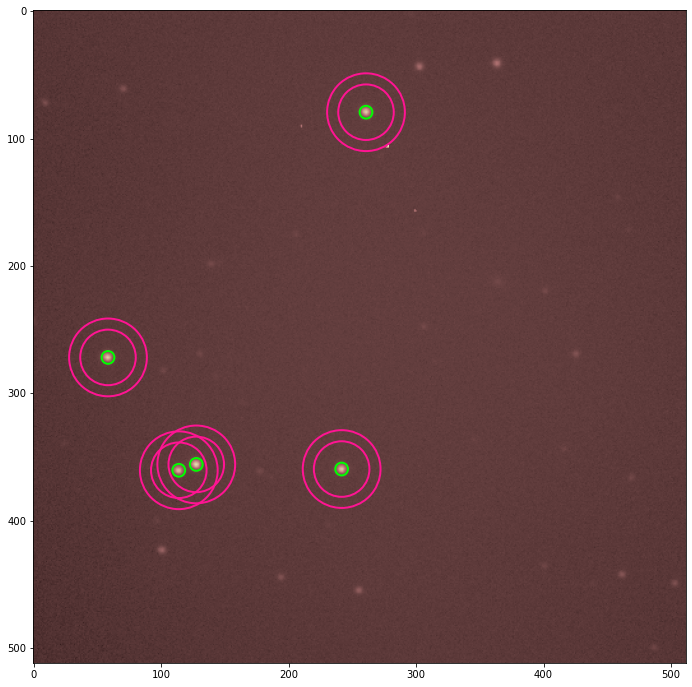

In [35]:
dao = DAOStarFinder(fwhm=2.18, threshold=100*std)
sources = dao(sciimg_data - median)
print(sources)

positions = []
for i, j in zip(sources['xcentroid'], sources['ycentroid']):
    positions.append((i,j));

apertures = CircularAperture(positions, r=5)
norm = ImageNormalize(stretch=SqrtStretch())

# wanted star is at xcent (208.95246610163315, 171.59263980420403)
annulus = CircularAnnulus(positions,r_in = 21.8,r_out = 30.52)
plt.figure(figsize=(12,12))
annulus.plot(color='deeppink', linewidth=2)
apertures.plot(color='lime',linewidth=2)
plt.imshow(sciimg_data, norm=norm, cmap='pink');
total_sky = aperture_photometry(sciimg_data,annulus)['aperture_sum']
avg_sky = total_sky / annulus.area
sky = avg_sky * apertures.area
fluxes = sources['flux'].data - sky.data

In [32]:
print(fluxes)

[-721.69900656 -676.08961395 -698.63474605 -723.53970591 -692.09955475]
